In [ ]:
pip install --quiet langchain langchain-community unstructured langgraph langchain_openai

In [ ]:
pip install --quiet langgraph-checkpoint-sqlite

In [ ]:
pip install --quiet networkx matplotlib

In [ ]:
from langgraph.graph import StateGraph, END
from typing import TypedDict, Annotated, List
import operator
from langchain_core.messages import AnyMessage, SystemMessage, HumanMessage, AIMessage, ChatMessage
from langgraph.checkpoint.sqlite import SqliteSaver

memory = SqliteSaver.from_conn_string(":memory:")

In [ ]:
class AgentState(TypedDict):
    task: str
    plan: str
    feedback: str
    critique: str
    content: List[str]
    revision_number: int
    max_revisions: int

In [ ]:
import os
from langchain_openai import ChatOpenAI
from google.colab import userdata

os.environ['OPENAI_API_KEY'] = userdata.get('openAI')
model = ChatOpenAI(model="gpt-3.5-turbo", temperature=0)

In [ ]:
os.environ["LANGCHAIN_TRACING_V2"] = "true"
os.environ["LANGCHAIN_ENDPOINT"] = "http://api.langchain.plus"
os.environ["LANGCHAIN_API_KEY"] = userdata.get('langsmith')

In [ ]:
Initial_Prompt="""You are an expert writer tasked with writing a high level outline of an essay. \
Write such an outline for the user provided topic. Give an outline of the essay along with any relevant notes \
or instructions for the sections."""

Refine_Prompt="Enhance the following output based on the feedback provided. Output: {output}, Feedback: {feedback}"

Feedback_Prompt="""You are a teacher grading an essay submission. \
Generate critique and recommendations for the user's submission. \
Provide detailed recommendations, including requests for length, depth, style, etc."""

In [ ]:
def initial_node(state: AgentState):
    messages = [
        SystemMessage(content=Initial_Prompt),
        HumanMessage(content=state['task'])
    ]
    response = model.invoke(messages)
    return {"plan": response.content}

In [ ]:
def feedback_node(state: AgentState):
    messages = [
        SystemMessage(content=Feedback_Prompt),
        HumanMessage(content=state['plan'])
    ]
    response = model.invoke(messages)
    return {"feedback": response.content}

In [ ]:
def refine_node(state: AgentState):
    messages = [
        SystemMessage(content= f"Enhance the following output based on the feedback provided. Output: {state['plan']}, Feedback: {state['feedback']}")
    ]
    response = model.invoke(messages)
    return {"plan": response.content}

In [ ]:
def condition_node(state: AgentState):
    return {
        "revision_number": state.get("revision_number", 1) + 1
    }

In [ ]:
def should_continue(state):
    if state["revision_number"] > state["max_revisions"]:
        return END
    return "Feedback"

In [ ]:
builder = StateGraph(AgentState)

builder.add_node("Initial", initial_node)
builder.add_node("Feedback", feedback_node)
builder.add_node("Refine", refine_node)
builder.add_node("condition", condition_node)

builder.set_entry_point("Initial")

builder.add_conditional_edges(
    "condition",
    should_continue,
    {END: END, "Feedback": "Feedback"}
)

builder.add_edge("Initial", "condition")
builder.add_edge("condition", "Feedback")

builder.add_edge("Feedback", "Refine")
builder.add_edge("Refine", "condition")


In [ ]:
with SqliteSaver.from_conn_string(":memory:") as checkpointer:
    graph = builder.compile(checkpointer=checkpointer)

In [ ]:
!apt-get -qq install -y graphviz graphviz-dev pkg-config

In [ ]:
pip install --quiet pygraphviz

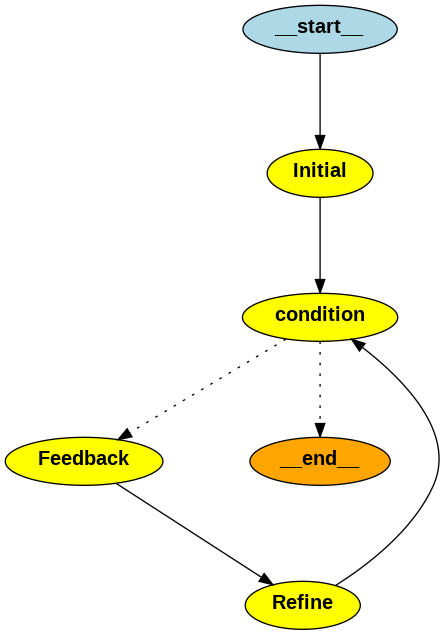

In [ ]:
from IPython.display import Image

Image(graph.get_graph().draw_png())

In [ ]:
thread = {"configurable": {"thread_id": "1"}}
with SqliteSaver.from_conn_string(":memory:") as checkpointer:
    graph = builder.compile(checkpointer=checkpointer)
    for s in graph.stream({
        'task': "renewable energy",
        "max_revisions": 2,
        "revision_number": 1,
    }, thread):print(s)

{'Initial': {'plan': "I. Introduction\n    A. Definition of renewable energy\n    B. Importance of transitioning to renewable energy sources\n    C. Thesis statement: The benefits of renewable energy outweigh the challenges in adopting it on a global scale.\n\nII. Types of Renewable Energy Sources\n    A. Solar energy\n    B. Wind energy\n    C. Hydropower\n    D. Geothermal energy\n    E. Biomass\n\nIII. Benefits of Renewable Energy\n    A. Environmental benefits\n        1. Reduction in greenhouse gas emissions\n        2. Conservation of natural resources\n    B. Economic benefits\n        1. Job creation\n        2. Energy independence\n    C. Social benefits\n        1. Improved public health\n        2. Energy access for all\n\nIV. Challenges in Adopting Renewable Energy\n    A. Initial high costs\n    B. Intermittency and storage issues\n    C. Infrastructure requirements\n    D. Policy and regulatory challenges\n\nV. Solutions to Overcome Challenges\n    A. Technological advanc

Content-Length: 8537
API Key: lsv2_********************************************27
post: trace=2e3c07fa-0e20-4897-ad58-765d4e9d466e,id=2e3c07fa-0e20-4897-ad58-765d4e9d466e; trace=2e3c07fa-0e20-4897-ad58-765d4e9d466e,id=c33e11ba-ed27-453f-b4e5-0ba6d8349c17; trace=2e3c07fa-0e20-4897-ad58-765d4e9d466e,id=fb0c72c6-31e6-402f-94e1-62dac1945077; trace=2e3c07fa-0e20-4897-ad58-765d4e9d466e,id=736f27f3-f430-4863-83c0-1f1a524b604e; trace=2e3c07fa-0e20-4897-ad58-765d4e9d466e,id=97eb2a76-b722-4799-a9e1-6c1524673d1c; trace=2e3c07fa-0e20-4897-ad58-765d4e9d466e,id=eafc6780-ca91-41f8-a6a9-b56b32396e7c


{'Refine': {'plan': "I. Introduction\n    A. Definition of renewable energy: Renewable energy refers to energy derived from naturally replenishing resources such as sunlight, wind, water, geothermal heat, and organic matter.\n    B. Importance of transitioning to renewable energy sources: With the increasing concerns about climate change, dwindling fossil fuel reserves, and energy security, transitioning to renewable energy sources is crucial for a sustainable future.\n    C. Thesis statement: The benefits of renewable energy, including environmental, economic, and social advantages, far outweigh the challenges in adopting it on a global scale.\n\nII. Types of Renewable Energy Sources\n    A. Solar energy: Solar power harnesses sunlight to generate electricity and heat, with photovoltaic cells and solar thermal systems being the primary technologies.\n    B. Wind energy: Wind turbines convert wind energy into electricity, offering a clean and abundant source of power.\n    C. Hydropowe

Content-Length: 60371
API Key: lsv2_********************************************27
post: trace=2e3c07fa-0e20-4897-ad58-765d4e9d466e,id=2b94fd1e-3c66-4697-8ccf-8855a86d793b; trace=2e3c07fa-0e20-4897-ad58-765d4e9d466e,id=45861796-8b32-426b-abb3-d397b629d598; trace=2e3c07fa-0e20-4897-ad58-765d4e9d466e,id=089945a8-a330-487f-9391-2d884fde4d90; trace=2e3c07fa-0e20-4897-ad58-765d4e9d466e,id=679b4056-b25b-437b-bdb9-dbb8612ba505; trace=2e3c07fa-0e20-4897-ad58-765d4e9d466e,id=eee93237-5668-4bf8-b40e-79e98998ac55; trace=2e3c07fa-0e20-4897-ad58-765d4e9d466e,id=bbc1d664-5654-405e-a776-709678433427; trace=2e3c07fa-0e20-4897-ad58-765d4e9d466e,id=b4d6c1e0-a49b-4952-959f-a88b2b4ecb24; trace=2e3c07fa-0e20-4897-ad58-765d4e9d466e,id=6e70d0fb-12f1-459c-bb0e-826136ea8ced; trace=2e3c07fa-0e20-4897-ad58-765d4e9d466e,id=41cae82c-b52a-4f97-bf15-9d9c763f75a2; patch: trace=2e3c07fa-0e20-4897-ad58-765d4e9d466e,id=97eb2a76-b722-4799-a9e1-6c1524673d1c; trace=2e3c07fa-0e20-4897-ad58-765d4e9d466e,id=eafc6780-ca91-41f8

{'Refine': {'plan': "I. Introduction\n    A. Definition of renewable energy: Renewable energy refers to energy derived from naturally replenishing resources such as sunlight, wind, water, geothermal heat, and organic matter. In today's rapidly evolving global energy landscape, the shift towards renewable sources has become imperative to combat climate change and ensure a sustainable future.\n    B. Importance of transitioning to renewable energy sources: With the increasing concerns about climate change, dwindling fossil fuel reserves, and energy security, transitioning to renewable energy sources is crucial for a sustainable future. The urgency to reduce greenhouse gas emissions and promote energy independence underscores the critical need for widespread adoption of renewable energy technologies.\n    C. Thesis statement: The benefits of renewable energy, including environmental, economic, and social advantages, far outweigh the challenges in adopting it on a global scale. By explorin

Content-Length: 116399
API Key: lsv2_********************************************27
post: trace=2e3c07fa-0e20-4897-ad58-765d4e9d466e,id=0c1749dd-5aa0-4691-9bb2-592c37d940bd; trace=2e3c07fa-0e20-4897-ad58-765d4e9d466e,id=8696a9aa-7529-469f-8071-a5ed2e2ab5f6; trace=2e3c07fa-0e20-4897-ad58-765d4e9d466e,id=bda2e434-81a9-437b-b5de-089cb932f561; trace=2e3c07fa-0e20-4897-ad58-765d4e9d466e,id=f1f8549f-6b86-40a6-945f-a0b5321f63f0; trace=2e3c07fa-0e20-4897-ad58-765d4e9d466e,id=40b0c0cc-47da-4d4b-900a-5b6489280691; trace=2e3c07fa-0e20-4897-ad58-765d4e9d466e,id=c24dadb3-5121-4f6c-9e49-b7b8607e218d; trace=2e3c07fa-0e20-4897-ad58-765d4e9d466e,id=b6999e81-e5f1-481f-a4dd-af2d3395334e; trace=2e3c07fa-0e20-4897-ad58-765d4e9d466e,id=079fce82-6895-4aa5-9ae0-b36ba2142096; trace=2e3c07fa-0e20-4897-ad58-765d4e9d466e,id=f580f2eb-5e2b-428f-8ee1-cc0b2154ccdc; patch: trace=2e3c07fa-0e20-4897-ad58-765d4e9d466e,id=6e70d0fb-12f1-459c-bb0e-826136ea8ced; trace=2e3c07fa-0e20-4897-ad58-765d4e9d466e,id=41cae82c-b52a-4f9

{'Feedback': {'feedback': 'Overall, your essay provides a comprehensive overview of renewable energy, covering various types of renewable energy sources, their benefits, challenges in adoption, solutions to overcome these challenges, and successful case studies. Here are some suggestions to enhance your submission:\n\n1. **Depth and Analysis**: While you have covered a wide range of topics related to renewable energy, consider delving deeper into specific examples or case studies to provide more detailed analysis. For instance, you could explore the specific economic impacts of renewable energy adoption in certain regions or the social benefits experienced by communities that have transitioned to renewable energy.\n\n2. **Engagement with Counterarguments**: To strengthen your argument, consider addressing potential counterarguments or criticisms of renewable energy. This could involve discussing common misconceptions about renewable energy, such as concerns about intermittency or the p

Content-Length: 117087
API Key: lsv2_********************************************27
post: trace=2e3c07fa-0e20-4897-ad58-765d4e9d466e,id=037ca159-022a-4b90-83de-733cf2495372; trace=2e3c07fa-0e20-4897-ad58-765d4e9d466e,id=9078487c-8097-4977-895d-bc55e3c2ab83; trace=2e3c07fa-0e20-4897-ad58-765d4e9d466e,id=f055a809-26ce-4b4f-9042-3d48f2907ad2; trace=2e3c07fa-0e20-4897-ad58-765d4e9d466e,id=d317eeb8-3948-4545-8854-430d0ced6c8b; trace=2e3c07fa-0e20-4897-ad58-765d4e9d466e,id=ac8d7bb8-f385-4d22-b4b6-e22cc72b5464; trace=2e3c07fa-0e20-4897-ad58-765d4e9d466e,id=099c7c57-1907-41cb-b1a9-471219f84e04; patch: trace=2e3c07fa-0e20-4897-ad58-765d4e9d466e,id=079fce82-6895-4aa5-9ae0-b36ba2142096; trace=2e3c07fa-0e20-4897-ad58-765d4e9d466e,id=f580f2eb-5e2b-428f-8ee1-cc0b2154ccdc


{'Refine': {'plan': "I. Introduction\n    A. Definition of renewable energy: Renewable energy refers to energy derived from naturally replenishing resources such as sunlight, wind, water, geothermal heat, and organic matter. In today's rapidly evolving global energy landscape, the shift towards renewable sources has become imperative to combat climate change and ensure a sustainable future.\n    B. Importance of transitioning to renewable energy sources: With the increasing concerns about climate change, dwindling fossil fuel reserves, and energy security, transitioning to renewable energy sources is crucial for a sustainable future. The urgency to reduce greenhouse gas emissions and promote energy independence underscores the critical need for widespread adoption of renewable energy technologies.\n    C. Thesis statement: The benefits of renewable energy, including environmental, economic, and social advantages, far outweigh the challenges in adopting it on a global scale. By explorin

Content-Length: 68234
API Key: lsv2_********************************************27
post: trace=2e3c07fa-0e20-4897-ad58-765d4e9d466e,id=61b48802-ba6e-45fd-9f0d-86b1906ea6f2; trace=2e3c07fa-0e20-4897-ad58-765d4e9d466e,id=874e5f9f-fe72-48d1-93d6-740eecd9d0b4; trace=2e3c07fa-0e20-4897-ad58-765d4e9d466e,id=edd6aa9c-6523-4363-8d53-e8c80eee0fb5; patch: trace=2e3c07fa-0e20-4897-ad58-765d4e9d466e,id=ac8d7bb8-f385-4d22-b4b6-e22cc72b5464; trace=2e3c07fa-0e20-4897-ad58-765d4e9d466e,id=099c7c57-1907-41cb-b1a9-471219f84e04


{'Refine': {'plan': "I. Introduction\n    A. Definition of renewable energy: Renewable energy refers to energy derived from naturally replenishing resources such as sunlight, wind, water, geothermal heat, and organic matter. In today's rapidly evolving global energy landscape, the shift towards renewable sources has become imperative to combat climate change and ensure a sustainable future.\n    B. Importance of transitioning to renewable energy sources: With the increasing concerns about climate change, dwindling fossil fuel reserves, and energy security, transitioning to renewable energy sources is crucial for a sustainable future. The urgency to reduce greenhouse gas emissions and promote energy independence underscores the critical need for widespread adoption of renewable energy technologies.\n    C. Thesis statement: The benefits of renewable energy, including environmental, economic, and social advantages, far outweigh the challenges in adopting it on a global scale. By explorin

Content-Length: 167979
API Key: lsv2_********************************************27
post: trace=2e3c07fa-0e20-4897-ad58-765d4e9d466e,id=f82a4367-8180-41cc-8c02-da6e7868877b; trace=2e3c07fa-0e20-4897-ad58-765d4e9d466e,id=dd2bc6f7-fbad-41b1-80b7-6d34814ecbe5; trace=2e3c07fa-0e20-4897-ad58-765d4e9d466e,id=c139a805-e6f1-471b-b81e-93953cefd7f0; trace=2e3c07fa-0e20-4897-ad58-765d4e9d466e,id=224b4785-338b-4256-be22-b6ef0641486a; trace=2e3c07fa-0e20-4897-ad58-765d4e9d466e,id=666a8556-318c-4b73-9a93-4e58d66a6d61; trace=2e3c07fa-0e20-4897-ad58-765d4e9d466e,id=e6263500-c499-4922-b4b4-311d6ebee1f1; trace=2e3c07fa-0e20-4897-ad58-765d4e9d466e,id=92e4298c-937e-4b7d-a85f-0ecfa45dfced; trace=2e3c07fa-0e20-4897-ad58-765d4e9d466e,id=3d7ecd67-cbd0-4f1d-8e8d-316d5c90303b; trace=2e3c07fa-0e20-4897-ad58-765d4e9d466e,id=14042241-9ed6-4014-91a9-7e7baf71a48f; patch: trace=2e3c07fa-0e20-4897-ad58-765d4e9d466e,id=874e5f9f-fe72-48d1-93d6-740eecd9d0b4; trace=2e3c07fa-0e20-4897-ad58-765d4e9d466e,id=edd6aa9c-6523-436

{'Feedback': {'feedback': "Overall, your essay provides a comprehensive overview of renewable energy, covering various types of renewable energy sources, their benefits, challenges in adoption, solutions to overcome these challenges, and successful case studies. Here are some suggestions to enhance your submission:\n\n1. **Depth and Analysis**: While you have covered a wide range of topics, consider delving deeper into specific aspects. For example, you could provide more detailed examples of how certain countries have successfully overcome challenges in adopting renewable energy or explore the specific economic impacts of renewable energy adoption in different regions.\n\n2. **Engagement with Counterarguments**: To strengthen your argument, consider addressing potential counterarguments against renewable energy adoption. This could involve discussing criticisms of renewable energy technologies, such as concerns about land use for solar farms or the intermittency of wind power, and pro

KeyboardInterrupt: 